# **ANALYSE & PRÉDICTION DE l'ORIGINE DES FORTUNES MONDIALES (2023)** 
### **BLOC 06 : DIRIGER UN PROJET DATA**

**Objectifs**
- Comprendre les facteurs déterminants qui séparent les entrepreneurs ("Self-Made") des héritiers parmi les 2 640 milliardaires mondiaux. 
- Construire un outil capable de prédire cette origine.

[Billionaires Statistics Dataset (2023) - Kaggle](https://www.kaggle.com/datasets/nelgiriyewithana/billionaires-statistics-dataset?resource=download)

---

### Importation des bibliothèques & Configuration

In [93]:
# Manipulation de données
import pandas as pd
import numpy as np

# Visualisation
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Métriques
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, recall_score, make_scorer
from sklearn.model_selection import learning_curve
from sklearn.metrics import silhouette_score

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Chargement et conversion du type 'object' en 'category'

In [2]:
# Chargement du dataset
df = pd.read_csv(r'billionaires_cleaned.csv')
print(f"Taille originale du dataset : {df.shape}")

# Conversion object → category car plus efficace en mémoire
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].astype('category')

Taille originale du dataset : (2640, 18)


In [3]:
# Vérification des types de données, des valeurs manquantes et de l'utilisation de la mémoire
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2640 entries, 0 to 2639
Data columns (total 18 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   finalWorth                                  2640 non-null   int64   
 1   age                                         2576 non-null   float64 
 2   country                                     2640 non-null   category
 3   industries                                  2640 non-null   category
 4   countryOfCitizenship                        2640 non-null   category
 5   selfMade                                    2640 non-null   bool    
 6   gender                                      2640 non-null   category
 7   cpi_country                                 2608 non-null   float64 
 8   cpi_change_country                          2608 non-null   float64 
 9   gdp_country                                 2628 non-null   float64 
 10  

---

## **PARTIE 3 | MACHINE LEARNING SUPERVISÉ**

### Fonction pour vérifier les courbes d'apprentissage (travail péparatoire)

In [4]:
def plot_learning_curve(estimator, X, y, title="Courbes d'apprentissage"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5), 
        scoring='accuracy' 
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Taille du jeu d'entraînement (Nombre d'exemples)")
    plt.ylabel("Score (Accuracy)")
    
    # Affichage de l'écart type (zone d'ombre) pour voir la stabilité
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score Entraînement (Train)")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score Validation (Cross-Val)")
    
    plt.legend(loc="best")
    plt.grid()
    plt.show()

### 1. Modélisation Baseline - Régression logistique

In [6]:
# Séparation Target / Features
# On retire les colonnes trop détaillées ou redondantes pour la baseline
X_baseline = df.drop(columns=['selfMade', 'industries', 'country', 'countryOfCitizenship'])
y_baseline = df['selfMade']

# Split Train / Test
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(X_baseline, y_baseline, test_size=0.2, random_state=42, stratify=y_baseline)

print(f"Dimensions Train : X={X_train_baseline.shape}, y={y_train_baseline.shape}")
print(f"Dimensions Test  : X={X_test_baseline.shape}, y={y_test_baseline.shape}")

Dimensions Train : X=(2112, 14), y=(2112,)
Dimensions Test  : X=(528, 14), y=(528,)


In [7]:
# Définition des types de colonnes
num_features_baseline = X_baseline.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features_baseline = X_baseline.select_dtypes(include=['category', 'bool']).columns.tolist()

print(f"Features numériques : {num_features_baseline}")
print(f"Features catégorielles : {cat_features_baseline}")

# Pipeline Numérique
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline Catégoriel
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Processeur final
preprocessor_baseline = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features_baseline),
        ('cat', cat_pipeline, cat_features_baseline)
    ]
)

Features numériques : ['finalWorth', 'age', 'cpi_country', 'cpi_change_country', 'gdp_country', 'gross_tertiary_education_enrollment', 'gross_primary_education_enrollment_country', 'life_expectancy_country', 'tax_revenue_country_country', 'total_tax_rate_country', 'population_country']
Features catégorielles : ['gender', 'industry_group', 'continent']


In [8]:
# Création du pipeline complet : Preprocessing + Modèle
model_lr = Pipeline([
    ('preprocessor', preprocessor_baseline),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Entraînement
model_lr.fit(X_train_baseline, y_train_baseline)

# Prédictions
y_pred_lr = model_lr.predict(X_test_baseline)

# Évaluation
print("--- BASELINE : RÉGRESSION LOGISTIQUE ---")
print(f"Accuracy : {accuracy_score(y_test_baseline, y_pred_lr):.4f}")
print("\nClassification Report :")
print(classification_report(y_test_baseline, y_pred_lr))

--- BASELINE : RÉGRESSION LOGISTIQUE ---
Accuracy : 0.7235

Classification Report :
              precision    recall  f1-score   support

       False       0.60      0.37      0.46       166
        True       0.75      0.89      0.81       362

    accuracy                           0.72       528
   macro avg       0.68      0.63      0.63       528
weighted avg       0.70      0.72      0.70       528



**Piège de l'Accuracy (72%)** \
À première vue, le modèle semble performant, mais ce chiffre est gonflé par la classe majoritaire ("Self-Made"). \
Si le modèle prédisait "Self-Made" pour tout le monde sans réfléchir, il aurait déjà une accuracy d'environ 68%. Le gain réel n'est donc que de ~4%.

**Problème du "Rappel" (Recall) sur la classe minoritaire "Héritage"** \
Le modèle ne détecte que **37%** des véritables héritiers. Il en rate près de 2 sur 3 !

Cette régression logistique est conservatrice. Elle a du mal à tracer une frontière linéaire claire pour identifier les héritiers. \
Elle servira de **point de référence**.

Génération des courbes - Régression logistique...


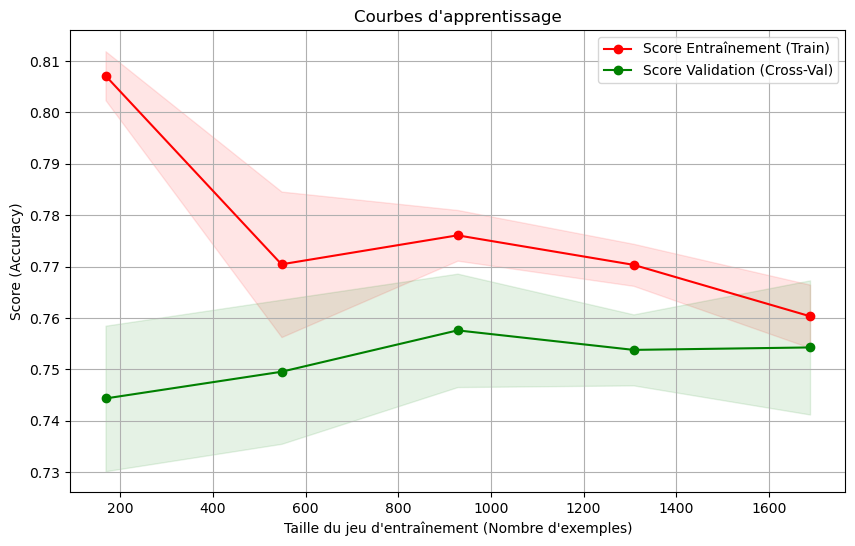

In [90]:
# Visualisation des courbes d'apprentissage
print(f"Génération des courbes - Régression logistique...")
plot_learning_curve(model_lr, X_train_baseline, y_train_baseline)

**Observation** \
Les deux courbes (Train en rouge, Val en vert) convergent très vite et se rejoignent presque parfaitement autour de 75%. \
Le score d'entraînement est faible (il ne monte pas à 100%).

**Diagnostic** \
Sous-apprentissage (High Bias → Underfitting ). \
Le modèle est trop simple pour capturer la complexité des données.

**Décision** \
Ajouter plus de données ne servira à rien. Il faut opter pour un modèle plus complexe.

### 2. Modélisation avancée : Random Forest

In [10]:
# Redéfinition des features (granulaires)
# On garde les colonnes précises (country, industries) et jette les agrégats (continent, industry_goup)
X = df.drop(columns=['selfMade', 'continent', 'industry_group'])
y = df['selfMade']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Mise à jour du Preprocessing
cat_features = X.select_dtypes(include=['category', 'bool']).columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ]
)

In [11]:
model_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        random_state=42, 
        class_weight='balanced',
        n_jobs=-1
    ))
])

# Entraînement
model_rf.fit(X_train, y_train)

# Prédictions
y_pred_rf = model_rf.predict(X_test)

# Évaluation
print("---- RANDOM FOREST (avec class_weight='balanced') ----")
print(f"\nAccuracy : {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report :")
print(classification_report(y_test, y_pred_rf))

---- RANDOM FOREST (avec class_weight='balanced') ----

Accuracy : 0.7689

Classification Report :
              precision    recall  f1-score   support

       False       0.65      0.56      0.60       166
        True       0.81      0.86      0.84       362

    accuracy                           0.77       528
   macro avg       0.73      0.71      0.72       528
weighted avg       0.76      0.77      0.76       528



L'utilisation du Random Forest avec la pondération des classes (`class_weight='balanced'`) a eu l'effet escompté :

- **Bond du Rappel (Recall) sur "Héritage" :** on passe de **0.37 à 0.56**. \
Le Random Forest détecte désormais plus de la moitié des héritiers. C'est un gain de performance pour la capacité de détection.

- **Stabilité de la Précision :** La précision de **65%** signifie que lorsque le modèle identifie un héritier, il a raison près de 2 fois sur 3.

- **Globalement l'Accuracy** monte à **77%**. \
Le modèle commence à capturer des nuances non-linéaires (peut-être des interactions comme "Jeune + Technologie = Self-Made" vs "Jeune + Mode = Héritage") que la régression logistique ne voyait pas.

Ce modèle est meilleur, mais un Recall de 56% reste un peu médiocre. Il faut tenter de réduire encore les "Faux Négatifs" (les héritiers classés dans "Self-Made").

Génération des courbes - Random Forest...


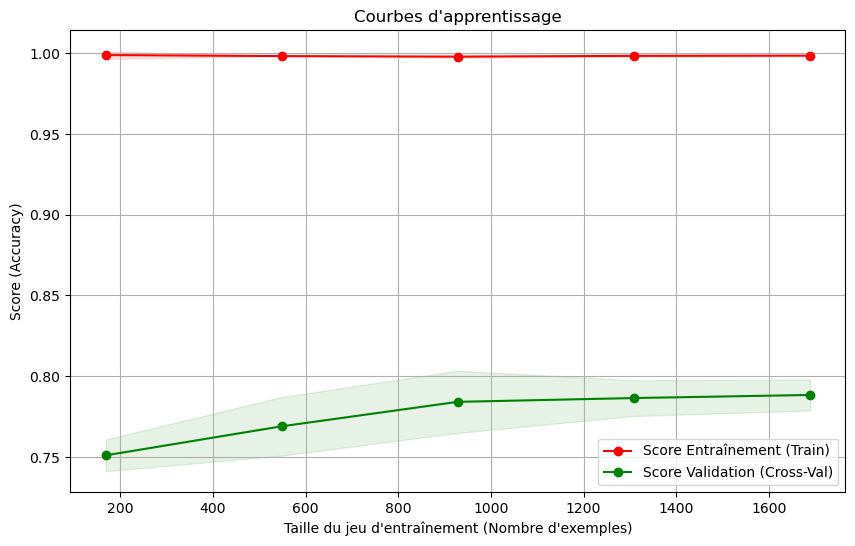

In [91]:
# Visualisation des courbes d'apprentissage
print(f"Génération des courbes - Random Forest...")
plot_learning_curve(model_rf, X_train, y_train)

**Observation** \
La courbe rouge (Train) est très haute (proche de 100%), car le Random Forest apprend par cœur les données d'entraînement. \
La courbe verte (Val) est plus basse (78-79%). \
Il y a un écart significatif (Gap) entre les deux lignes.

**Diagnostic**
Sur-apprentissage (High Variance → Overfitting). \
Le modèle est excellent sur ce qu'il connaît, mais a du mal à généraliser.

**Décision** \
Ce modèle bénéficierait de plus de données (pour faire remonter la ligne verte) ou d'une régularisation (limiter la profondeur des arbres).

### 3. Modélisation Challenger : XGBoost

In [14]:
# Calcul du ratio pour l'équilibrage des classes
# scale_pos_weight = count(negative) / count(positive)
# Ici, "0" (Héritage) est la classe minoritaire et "1" (Self-Made) la classe majoritaire.
# En donnant ce ratio, XGBoost augmente le poids des erreurs sur la classe 1.
# Cela a pour effet indirect d'améliorer le rappel sur la classe minoritaire (0),
# au prix d'un rappel un peu plus faible sur la classe majoritaire (1).

weight_ratio = float(y_train.value_counts()[False]) / float(y_train.value_counts()[True])
ratio = weight_ratio
print(f"Ratio calculé pour scale_pos_weight : {ratio:.3f}\n")

model_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=weight_ratio,
    ))
])

# Entraînement
model_xgb.fit(X_train, y_train)

# Prédictions
y_pred_xgb = model_xgb.predict(X_test)

# Évaluation
print("--------------- XGBOOST (Gradient Boosting) ---------------")
print(f"\nAccuracy : {accuracy_score(y_test, y_pred_xgb):.4f}")
print("\nClassification Report :")
print(classification_report(y_test, y_pred_xgb, target_names=['Héritage (False)', 'Self-Made (True)']))

Ratio calculé pour scale_pos_weight : 0.457

--------------- XGBOOST (Gradient Boosting) ---------------

Accuracy : 0.7311

Classification Report :
                  precision    recall  f1-score   support

Héritage (False)       0.56      0.69      0.62       166
Self-Made (True)       0.84      0.75      0.79       362

        accuracy                           0.73       528
       macro avg       0.70      0.72      0.70       528
    weighted avg       0.75      0.73      0.74       528



En ajustant le paramètre `scale_pos_weight` à **0.46** (ratio minoritaire/majoritaire), nous inversons la tendance du modèle qui favorise trop la classe majoritaire.

**Rappel (Recall) Héritage : 69%**.
Le modèle identifie désormais correctement 7 héritiers sur 10.
  
**Compromis :** la précision a baissé à 56% (contre 65%  pour le Random Forest), ce qui est attendu. \
Pour attraper plus d'héritiers, le modèle accepte de faire quelques erreurs (classer certains entrepreneurs dans "Héritage"), ce qui est acceptable dans une logique de détection de profils mais à surveiller.

### 4. Benchmark des modèles avec validation croisée (GridSearch)

In [ ]:
# Configuration des mmodèles à tester
# Validation croisée avec GridSearchCV pour hyperparamètres tuning

results_list = []

models_to_test = [
    {
        'name': 'Decision Tree',
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'classifier__max_depth': [15, 20, 25],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__class_weight': ['balanced']
        }
    },
    {
        'name': 'Random Forest',
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100, 150, 200],
            'classifier__max_depth': [5, 10, 15],
            'classifier__min_samples_leaf': [4, 5, 6],
            'classifier__class_weight': ['balanced']
        }
    },
    {
        'name': 'XGBoost',
        'model': XGBClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.04, 0.05],
            'classifier__max_depth': [5, 6],
            'classifier__scale_pos_weight': [0.457], # ratio optimisé
        }
    },
    {
        'name': 'AdaBoost',
        'model': AdaBoostClassifier(
            estimator=DecisionTreeClassifier(random_state=42),
            random_state=42
        ),
        'params': {
            'classifier__n_estimators': [100, 150, 175],
            'classifier__learning_rate': [0.5, 1.0, 1.5],
            'classifier__estimator__class_weight': ['balanced']
        }
    }
]

In [48]:
# Boucle d'entraînement

print("Début de la comparaison des modèles...")
print("-" * 50)

best_overall_model = None
best_overall_score = 0
best_model_name = ""

for m in models_to_test:
    print(f"Entraînement de : {m['name']}...")
    
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', m['model'])
    ])
    
    # Recherche des hyperparamètres pour optimiser le F1-Score (compromis entre les classes)
    grid = GridSearchCV(pipe, m['params'], cv=5, scoring='f1_macro', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    y_pred_test = grid.predict(X_test)
    y_pred_train = grid.predict(X_train)
    
    # Métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    
    # Recall Self-Made (classe 1)
    recall_selfmade = recall_score(y_test, y_pred_test, pos_label=1)
    
    # Recall Héritage (classe 0)
    recall_heritage = recall_score(y_test, y_pred_test, pos_label=0)
    
    if f1_test > best_overall_score:
        best_overall_score = f1_test
        best_overall_model = grid.best_estimator_
        best_model_name = m['name']
    
    gap = accuracy_score(y_train, y_pred_train) - acc_test
    
    results_list.append({
        'Modèle': m['name'],
        'Accuracy': acc_test,
        'F1-Score': f1_test,
        'Recall (Self-Made)': recall_selfmade,
        'Recall (Héritage)': recall_heritage,
        'Overfitting': gap,
        'Best Params': str(grid.best_params_)
    })

print("-" * 50)
print("Comparaison terminée !")

Début de la comparaison des modèles...
--------------------------------------------------
Entraînement de : Decision Tree...
Entraînement de : Random Forest...
Entraînement de : XGBoost...
Entraînement de : AdaBoost...
--------------------------------------------------
Comparaison terminée !


In [49]:
df_results = pd.DataFrame(results_list).set_index("Modèle")
df_results = df_results.sort_values(by="Recall (Héritage)", ascending=False)

display(df_results.style.background_gradient(cmap='Blues', subset=['F1-Score', 'Accuracy','Recall (Héritage)']))

,Accuracy,F1-Score,Recall (Self-Made),Recall (Héritage),Overfitting,Best Params
Modèle,,,,,,
XGBoost,0.736742,0.797080,0.754144,0.698795,0.137311,"{'classifier__learning_rate': 0.05, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 0.457}"
Random Forest,0.721591,0.783505,0.734807,0.692771,0.083807,"{'classifier__class_weight': 'balanced', 'classifier__max_depth': 15, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 100}"
Decision Tree,0.704545,0.769912,0.720994,0.668675,0.190341,"{'classifier__class_weight': 'balanced', 'classifier__max_depth': 25, 'classifier__min_samples_split': 10}"
AdaBoost,0.708333,0.787293,0.787293,0.536145,0.289773,"{'classifier__estimator__class_weight': 'balanced', 'classifier__learning_rate': 1.5, 'classifier__n_estimators': 150}"


### 5. Focus sur XGBoost Best Model

In [56]:
# Zoom sur le gagnant

print(f"DÉTAILS DU MEILLEUR MODÈLE : {best_model_name}")
print("-" * 55)

y_pred_best = best_overall_model.predict(X_test)
print(classification_report(y_test, y_pred_best))

DÉTAILS DU MEILLEUR MODÈLE : XGBoost
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.57      0.70      0.63       166
        True       0.85      0.75      0.80       362

    accuracy                           0.74       528
   macro avg       0.71      0.73      0.71       528
weighted avg       0.76      0.74      0.74       528



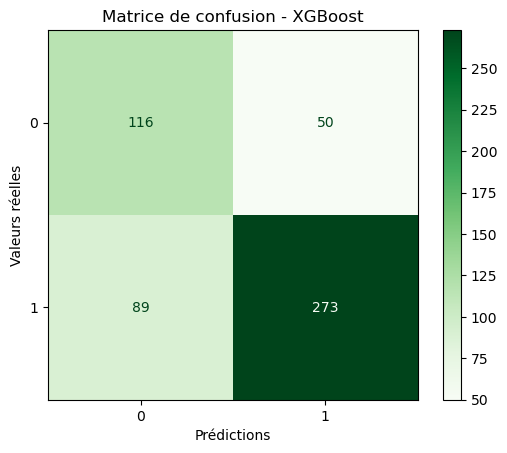

In [57]:
# Matrice de confusion

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_overall_model.classes_)
disp.plot(cmap="Greens") 

plt.title(f"Matrice de confusion - {best_model_name}")
plt.ylabel("Valeurs réelles")
plt.xlabel("Prédictions")
plt.show()

Génération des courbes pour le meilleur modèle XGBoost...


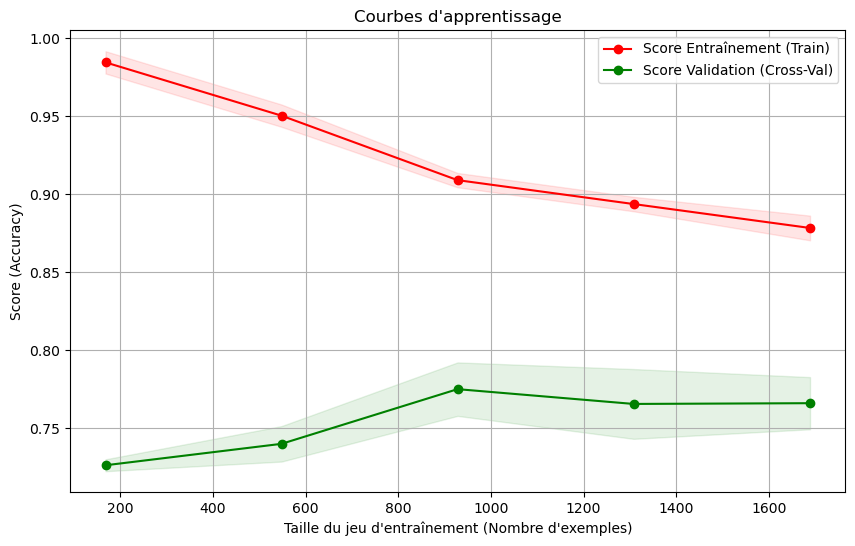

In [58]:
print(f"Génération des courbes pour le meilleur modèle {best_model_name}...")
plot_learning_curve(best_overall_model, X_train, y_train)

**Observation** \
La courbe d'entraînement (rouge) descend un peu (il n'apprend pas bêtement par cœur comme le RF). \
La courbe de validation (verte) remonte progressivement pour atteindre un plateau.

**Diagnostic**
C'est le meilleur compromis Biais/Variance. \
L'écart entre le Train et le Val est moins caricatural que sur le Random Forest, et le score final est meilleur que la Régression Logistique.

**Conclusion** \
Le plateau de la courbe verte suggère que nous avons atteint la performance maximale possible avec ces variables actuelles. \
Pour aller plus haut, il ne faut pas plus de lignes, mais de meilleures colonnes (Feature Engineering ou NLP).

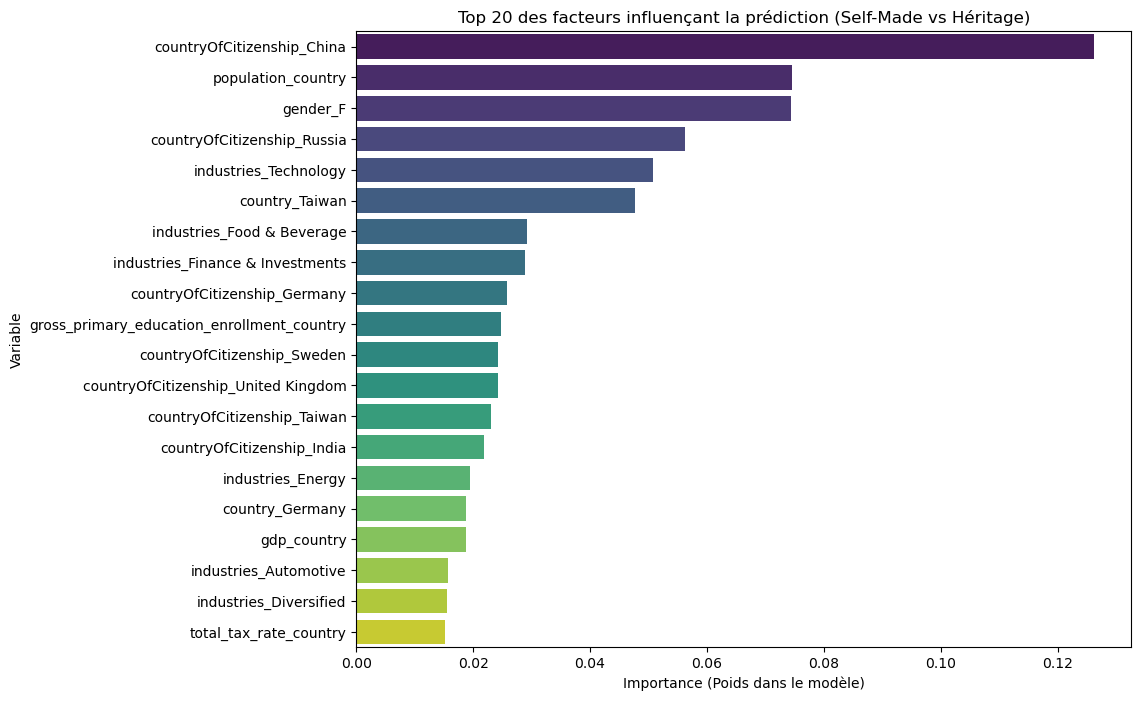

                                        feature  importance
115                  countryOfCitizenship_China    0.126331
10                           population_country    0.074495
176                                    gender_F    0.074438
157                 countryOfCitizenship_Russia    0.056199
101                       industries_Technology    0.050798
74                               country_Taiwan    0.047717
91                   industries_Food & Beverage    0.029168
90             industries_Finance & Investments    0.028808
126                countryOfCitizenship_Germany    0.025736
6    gross_primary_education_enrollment_country    0.024767
163                 countryOfCitizenship_Sweden    0.024185
171         countryOfCitizenship_United Kingdom    0.024163
165                 countryOfCitizenship_Taiwan    0.022990
132                  countryOfCitizenship_India    0.021823
88                            industries_Energy    0.019477
34                              country_

In [59]:
# Récupération des importances du modèle (version granulaire)
best_model_xgb = best_overall_model.named_steps['classifier']

# On reconstruit les noms de features à partir des listes utilisées lors du fit (num_features, cat_features)
ohe_obj = best_overall_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
feature_names_cat = ohe_obj.get_feature_names_out(cat_features)
all_feature_names = np.r_[num_features, feature_names_cat]

feature_importances = pd.DataFrame({
	'feature': all_feature_names, 
	'importance': best_model_xgb.feature_importances_
})

# Tri par ordre décroissant
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Affichage du Top 20
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20), palette='viridis')
plt.title('Top 20 des facteurs influençant la prédiction (Self-Made vs Héritage)')
plt.xlabel('Importance (Poids dans le modèle)')
plt.ylabel('Variable')
plt.show()

# Affichage des 20 premières valeurs exactes
print(feature_importances.head(20))

### 5. Feature engineering

In [61]:
# Création de nouvelles features dans une copie du DataFrame original
df_feat = df.copy()

# Richesse par année d'âge (Proxy de la vitesse d'accumulation)
df_feat['wealth_per_year'] = df_feat['finalWorth'] / df_feat['age']

# Poids économique (Richesse / PIB du pays)
# Permet de normaliser la richesse : 1 milliard au Burundi vs aux USA n'a pas le même sens
df_feat['wealth_to_gdp_ratio'] = df_feat['finalWorth'] / df_feat['gdp_country']

In [70]:
# Préparation des données avec les nouvelles features
X_eng = df_feat.drop(columns=['selfMade', 'continent', 'industry_group'])
y_eng = df_feat['selfMade']

# Split
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_eng, y_eng, test_size=0.2, random_state=42, stratify=y_eng)

# Mise à jour de la liste des features numériques (car on en a ajouté 2)
num_features_e = X_eng.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features_e = X_eng.select_dtypes(include=['category', 'bool']).columns.tolist()

# Pipeline (On reprend exactement le même)
preprocessor_e = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features_e),
        ('cat', cat_pipeline, cat_features_e)
    ]
)

# Entraînement Final (XGBoost Optimisé) 
model_xgb_eng = Pipeline([
    ('preprocessor', preprocessor_e),
    ('classifier', XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        scale_pos_weight=0.457, # le ratio optimisé
        random_state=42,
        n_jobs=-1
    ))
])

model_xgb_eng.fit(X_train_e, y_train_e)
y_pred_e = model_xgb_eng.predict(X_test_e)

print("---------- XGBOOST FINAL + FEATURE ENGINEERING ----------\n")
print(classification_report(y_test_e, y_pred_e, target_names=['Héritage (False)', 'Self-Made (True)']))

---------- XGBOOST FINAL + FEATURE ENGINEERING ----------

                  precision    recall  f1-score   support

Héritage (False)       0.57      0.69      0.63       166
Self-Made (True)       0.84      0.77      0.80       362

        accuracy                           0.74       528
       macro avg       0.71      0.73      0.72       528
    weighted avg       0.76      0.74      0.75       528



L'ajout de variables macro-économiques calculées (`wealth_per_year`, `wealth_to_gdp`) n'a pas bouleversé les performances du modèle. \
Il plafonne autour de **74% d'Accuracy** et **70% de Recall** sur la cible prioritaire ("Héritage").

In [69]:
# Vérifions si les nouvelles features servent à quelque chose
best_model_xgb_eng = model_xgb_eng.named_steps['classifier']
ohe_obj = model_xgb_eng.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
feature_names_cat = ohe_obj.get_feature_names_out(cat_features_e)
all_feature_names = np.r_[num_features_e, feature_names_cat]

df_imp_eng = pd.DataFrame({'Feature': all_feature_names, 'Importance': best_model_xgb_eng.feature_importances_})
print("Top 15 des Features les plus importantes :\n")
print("-" * 60)
print(df_imp_eng.sort_values(by='Importance', ascending=False).head(15))

Top 15 des Features les plus importantes :

------------------------------------------------------------
                                        Feature  Importance
117                  countryOfCitizenship_China    0.141159
10                           population_country    0.095603
178                                    gender_F    0.077036
159                 countryOfCitizenship_Russia    0.051260
103                       industries_Technology    0.050183
92             industries_Finance & Investments    0.035300
134                  countryOfCitizenship_India    0.030890
93                   industries_Food & Beverage    0.027912
6    gross_primary_education_enrollment_country    0.027312
76                               country_Taiwan    0.026980
173         countryOfCitizenship_United Kingdom    0.022467
90                            industries_Energy    0.021849
128                countryOfCitizenship_Germany    0.019765
165                 countryOfCitizenship_Sweden    0.01

L'analyse des variables les plus influentes révèle une hiérarchie claire des déterminants de la richesse :

**L'origine géographique (facteur n°1)** \
La citoyenneté (Chine, Russie, Taiwan) est le prédictif le plus puissant. \
Cela reflète sans doute les contextes historiques récents de ces pays (émergence rapide du capitalisme) qui favorisent massivement les profils *Self-Made*.

**Le genre (facteur social)** \
La variable `Gender_F` arrive en 3ème position. \
Statistiquement, être une femme dans ce dataset augmente considérablement la probabilité d'être une héritière, un reflet des inégalités d'accès à l'entrepreneuriat à très grande échelle.

**Le secteur d'activité** \
La "Technologie" est un marqueur fort de réussite entrepreneuriale, tandis que des secteurs plus traditionnels sont moins discriminants.

### **Bilan intermédiaire (ML supervisé)**

Nous avons réussi à construire un modèle capable de détecter **70% des héritiers** (contre 37% pour la baseline). \
Cependant, une "zone grise" subsiste (~25% d'erreurs) !

Pour aller plus loin et comprendre ces profils complexes, nous allons changer d'approche et utiliser le **Machine Learning non-supervisé (Clustering)**.

---

## **PARTIE 4 | MACHINE LEARNING NON SUPERVISÉ**

### 1. Préparation des données

In [71]:
# Application du même preprocessing que précédemment
print("Transformation des données...")
X_processed = preprocessor.fit_transform(X)

Transformation des données...


### 2. PCA (Analyse en Composantes Principales)

In [72]:
# Réduction à 4 dimensions pour capturer le maximum de variance
pca = PCA(n_components=4)
components = pca.fit_transform(X_processed)

# Création d'un DataFrame pour faciliter l'affichage avec Plotly
df_pca = pd.DataFrame(data=components, columns=['PC1', 'PC2', 'PC3', 'PC4'])
df_pca['Real_Label'] = y.values.astype(str)  # La vraie classe (Self-Made vs Héritage) pour comparaison

# Affichage de la variance expliquée (Combien d'info avons-nous gardé ?)
explained_var = np.sum(pca.explained_variance_ratio_) * 100
print(f"Variance expliquée par les 4 axes : {explained_var:.2f}%")

Variance expliquée par les 4 axes : 61.99%


### 3. K-Means

In [95]:
# Visualisation combinée de l'inertie et du score de silhouette

# Calcul de l'inertie (WCSS) et du score de silhouette pour différentes valeurs de k
wcss, sil, k = [], [], []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto').fit(X_processed)
    wcss.append(kmeans.inertia_)
    sil.append(silhouette_score(X_processed, kmeans.labels_))
    k.append(i)
    print(f"For k = {i} --> WCSS = {wcss[-1]} | Silhouette = {sil[-1]}")

# Création d'une figure combinée avec deux axes y
fig = go.Figure()

# Ajout du score de silhouette en barres (axe y de gauche)
fig.add_trace(
    go.Bar(x=k, y=sil, name="Silhouette score", yaxis="y1")
)

# Ajout de l'inertie en ligne (axe y de droite)
fig.add_trace(
    go.Scatter(x=k, y=wcss, mode="lines+markers", name="Inertia", yaxis="y2")
)

# Mise à jour de la mise en page avec deux axes y
fig.update_layout(
    title="KMeans clustering evaluation metrics",
    xaxis=dict(title="# Clusters"),
    yaxis=dict(title="Silhouette score", side="left"),
    yaxis2=dict(title="Inertia", overlaying="y", side="right"),
    legend=dict(x=0.5, y=-0.2, orientation="h")
)

fig.show()

For k = 2 --> WCSS = 29805.360165517843 | Silhouette = 0.21825987438721708
For k = 3 --> WCSS = 24279.334848355214 | Silhouette = 0.27529283283866895
For k = 4 --> WCSS = 22064.948667287026 | Silhouette = 0.2937028556997502
For k = 5 --> WCSS = 20693.898564058236 | Silhouette = 0.2988997642805762
For k = 6 --> WCSS = 20106.864172899786 | Silhouette = 0.2044319806878495
For k = 7 --> WCSS = 15857.228311661867 | Silhouette = 0.2743857155670938
For k = 8 --> WCSS = 15053.222482817037 | Silhouette = 0.3478418224137167
For k = 9 --> WCSS = 13532.281925639658 | Silhouette = 0.3583605632223839
For k = 10 --> WCSS = 13193.111978872277 | Silhouette = 0.3524875415438344


**Lecture des indicateurs** 

- ***WCSS (Within-Cluster Sum of Squares)*** mesure la compacité des clusters (inertie). \
Plus il est bas, mieux les points sont regroupés. \
Il diminue régulièrement avec k (normal), mais l’important est de repérer le “coude” où la baisse devient moins significative.

- ***Silhouette*** mesure la qualité de la séparation des clusters (entre -1 et 1). \
Plus c’est haut, mieux les clusters sont distincts et cohérents. \
Ici, les valeurs sont modestes (<0.4), mais on observe une nette amélioration à partir de k=8.

**Analyse**
- k=2 → 5 : WCSS baisse fortement, mais les silhouettes restent faibles (0.21 → 0.29). Les clusters sont compacts mais pas très bien séparés.
- k=6 : silhouette chute brutalement (0.20), signe d’un mauvais partitionnement.
- k=7 : silhouette remonte un peu (0.27), mais reste moyenne.
- k=8 → 9 → 10 : silhouette s’améliore nettement (0.35–0.36), ce qui indique des clusters plus cohérents.\
WCSS continue de baisser, mais la différence entre k=9 et k=10 est faible.\
***Silhouette maximale à k=9 (0.358)***.

In [ ]:
# Analyse des clusters avec k=9
k = 9
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_processed)
df_pca['Cluster'] = kmeans.fit_predict(X_processed).astype(str)

# Visualisation 2D pour une meilleure lisibilité : Axes PC1 vs PC2
# Couleur = cluster K-Means (ce que la machine voit)
# Forme = classe réelle (ce qu'on cherche à prédire)
fig_pca_k9 = px.scatter(
    df_pca, x='PC1', y='PC2',
    color='Cluster', 
    symbol='Real_Label',
    title=f"Projection PCA 2D & Clusters K-Means (k={k})",
    hover_data=['PC3', 'PC4'],
    height=600,
    width=1200,
    opacity=0.7,
    color_discrete_sequence=px.colors.qualitative.Bold
)
fig_pca_k9.update_traces(marker=dict(size=9))
fig_pca_k9.show()

# Création d'un DataFrame d'analyse en reprenant les données brutes (df)
df_analysis = df.copy()
df_analysis['Cluster'] = labels
df_analysis['selfMade_Numeric'] = df_analysis['selfMade'].astype(int)

# Agrégation pour définir le "Profil Type" de chaque cluster
cluster_profile = df_analysis.groupby('Cluster').agg({
    'finalWorth': 'median',
    'age': 'mean',
    'selfMade_Numeric': 'mean',
    'country': lambda x: x.mode()[0] if not x.mode().empty else 'N/A',
    'industries': lambda x: x.mode()[0] if not x.mode().empty else 'N/A',
    'gender': lambda x: x.value_counts(normalize=True).get('F', 0) # % de Femmes
}).reset_index()

# Mise en forme
cluster_profile['age'] = cluster_profile['age'].round(1)
cluster_profile['selfMade_Numeric'] = (cluster_profile['selfMade_Numeric'] * 100).round(1)
cluster_profile['gender'] = (cluster_profile['gender'] * 100).round(1) # % Femmes
cluster_profile.columns = ['Cluster', 'Fortune Médiane', 'Age Moyen', '% Self-Made', 'Pays Dom.', 'Indus. Dom.', '% Femmes']

print(f"PROFIL TYPE DES {k} CLUSTERS (K-MEANS)")
print("-" * 190)
cluster_profile

PROFIL TYPE DES 9 CLUSTERS (K-MEANS)
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


,Cluster,Fortune Médiane,Age Moyen,% Self-Made,Pays Dom.,Indus. Dom.,% Femmes
0,0,1900.0,68.1,66.7,Turkey,Diversified,9.5
1,1,2900.0,67.3,71.6,United States,Finance & Investments,13.1
2,2,2300.0,64.3,57.7,United Kingdom,Fashion & Retail,17.9
3,3,1900.0,58.7,96.7,China,Manufacturing,10.3
4,4,2200.0,68.3,61.5,Hong Kong,Real Estate,11.7
5,5,2100.0,68.2,42.0,India,Manufacturing,8.3
6,6,2400.0,66.7,48.1,Germany,Fashion & Retail,17.3
7,7,79200.0,68.4,60.9,United States,Technology,13.0
8,8,2500.0,63.5,79.1,Russia,Diversified,6.5


#### Analyse des 9 archétypes de milliardaires (clustering K-Means)

L'algorithme a identifié 8 profils types. On constate que la géographie est le facteur discriminant principal, suivi par le secteur d'activité et l'origine de la fortune. \
On constate des spécialisations sectorielles régionales très nettes (Immobilier à Hong Kong, Retail en Europe).

**Cluster 0 | Conglomérats turcs et méditerranéens**
- Profil : hommes d'affaires gérant des holdings diversifiées, avec une forte dominante turque.
- Spécificité : cluster vieillissant (68 ans) avec un taux de Self-Made modéré (67%). \
Il représente typiquement les grandes familles ou entrepreneurs à la tête de groupes multisectoriels (Construction, Énergie, Tourisme) caractéristiques des économies émergentes de la région.

**Cluster 1 | Finance américaine (Wall Street)**
- Profil : investisseurs et gestionnaires de fonds américains.
- Spécificité : fortement "Self-Made" (72%), ce groupe incarne la méritocratie financière américaine. \
Il se distingue des géants de la Tech par des fortunes plus "modestes" (médiane à 2.9 Mrds dollars) mais très nombreuses.

**Cluster 2 | Retail & Mode britannique**
- Profil : fortunes du Royaume-Uni centrées sur la consommation.
- Spécificité : cluster le plus féminin (18%). \
Il mélange héritiers et entrepreneurs dans le secteur "Fashion & Retail", illustrant la puissance des marques et de la distribution londonienne.

**Cluster 3 | "Usine du monde" (industrie chinoise)** 
- Profil : cluster le plus jeune (59 ans) et le plus pur (97% de Self-Made).
- Spécificité : archétype de la croissance chinoise des 20 dernières années. \
Ce groupe très homogène rassemble quasi exclusivement des entrepreneurs de la manufacture partis de rien.

**Cluster 4 | Magnats de l'immobilier (Hong Kong)**
- Profil : élite foncière asiatique.
- Spécificité : très sectoriel ("Real Estate") et centré sur Hong Kong. \
Le Self-Made à 61% indique une transition : les bâtisseurs historiques cèdent peu à peu la place à la seconde génération qui gère ces empires immobiliers.

**Cluster 5 | Dynasties industrielles indiennes**
- Profil : groupe traditionnel masculin et vieillissant (68 ans).
- Spécificité : cluster avec le taux de "Self-Made" le plus faible (42%). \
Il capture parfaitement le modèle économique indien basé sur de grands conglomérats familiaux industriels (Manufacturing) qui se transmettent de génération en génération.

**Cluster 6 | Héritiers du commerce allemand**
- Profil : grandes fortunes familiales d'Allemagne.
- Spécificité : majoritairement des héritiers (seulement 48% de Self-Made). \
Contrairement au cliché de l'industrie lourde, ce cluster est dominé par le "Fashion & Retail" (type héritiers Aldi, Lidl, Otto), avec une forte présence féminine (17.3%).

**Cluster 7 | Titans ("Ultra-High-Net-Worth") & Géants de la Tech**
- Profil : maîtres du monde.
- Spécificité : anomalie statistique définie par la démesure de la fortune (médiane à 79.2 Mrds dollars, loin devant les autres) \
La médiane est à 79.2 Milliards $ (contre ~2 Mrds pour les autres). \
Il regroupe les fondateurs de la Tech US (Musk, Bezos, Gates, Mark Zuckerberg) mais aussi les héritiers de fortunes colossales (Arnault, Bettencourt Meyers, Ambani, Koch, Walton), d'où un taux de self-made moyen (61%). \
Ils sont isolés car ils n'ont "rien à voir" avec les autres milliardaires en termes d'échelle fiancière.

**Cluster 8 | Oligarques & Conglomérats russes**
- Profil : hommes d'affaires de l'ère post-soviétique.
- Spécificité : taux de femmes le plus bas du dataset (6,5%). \
Très "Self-Made" (79%) et "diversifiées", marqueur des oligarques ayant acquis des actifs dans de multiples secteurs (mines, énergie, banques) lors des privatisations.

**--> Le clustering confirme que l'origine de la fortune (Héritage vs Self-Made) n'est pas homogène :**
- *L'usine du monde :* industriels chinois (97% Self-Made).
- *L'exception américaine :* une stratification unique entre "Classe moyenne des milliardaires" (Finance) et "Titans" (Tech/Retail). \
Ces deux clusters distincts (Finance et Ultra-Riches), prouvent la profondeur et la diversité de leur écosystème de richesse.
- *Les dynasties :* profils européens et indiens où l'héritage prédomine.

---

## **SYNTHÈSE ET PERSPECTIVES**

#### **1. BILAN DE L'APPROCHE SUPERVISÉE** 
Un des objectifs cruciaux est rempli grâce au modèle XGBoost : ***détection de 70% des héritiers (Rappel)***, contre seulement 37% pour la baseline initiale. \
Cependant, la ***précision globale plafonne autour de 74%*** (pafond de verre).

Ce seuil semble structurel : avec des données uniquement tabulaires (âge, pays, secteur), il reste une marge d'erreur incompressible de 25%.

#### **2. APPORT DÉCISIF DU NON-SUPERVISÉ** 
Le clustering (k-Means, 9 groupes) a fourni la clé de compréhension du plafond de verre :

***Profils distincts*** \
Certains groupes sont très homogènes (ex: Cluster 3 "Industriels Chinois" = 97% Self-Made), et donc faciles à prédire.

***Zones Grises*** \
Les clusters occidentaux (USA/Europe) sont "mixtes". \
Ils regroupent des profils financièrement identiques mais d'origines différentes (ex: un héritier britannique et un investisseur britannique ont les mêmes métriques). \
Ils sont géométriquement indiscernables sans données supplémentaires.

#### **3. ROADMAP & AMÉLIORATIONS FUTURES** 
Pour dépasser les 74% de précision, l'optimisation des hyperparamètres ne suffira pas. Il faut enrichir la donnée :

***Piste cechnique (SMOTE)*** \
Tester la génération de données synthétiques pour mieux entraîner le modèle sur la classe minoritaire "Héritage".

***Piste Data (NLP)***\
C'est sans doute le levier le plus prometteur. \
Scraper les mini-biographies textuelles (Forbes/Bloomberg) et analyser les mots-clés ("founded", "father", "family business") permettrait de discriminer les profils mixtes que les chiffres seuls ne voient pas.